READING OPENFAST INPUT FILES
------------------------------------------------------------

Creating 3D visualization...


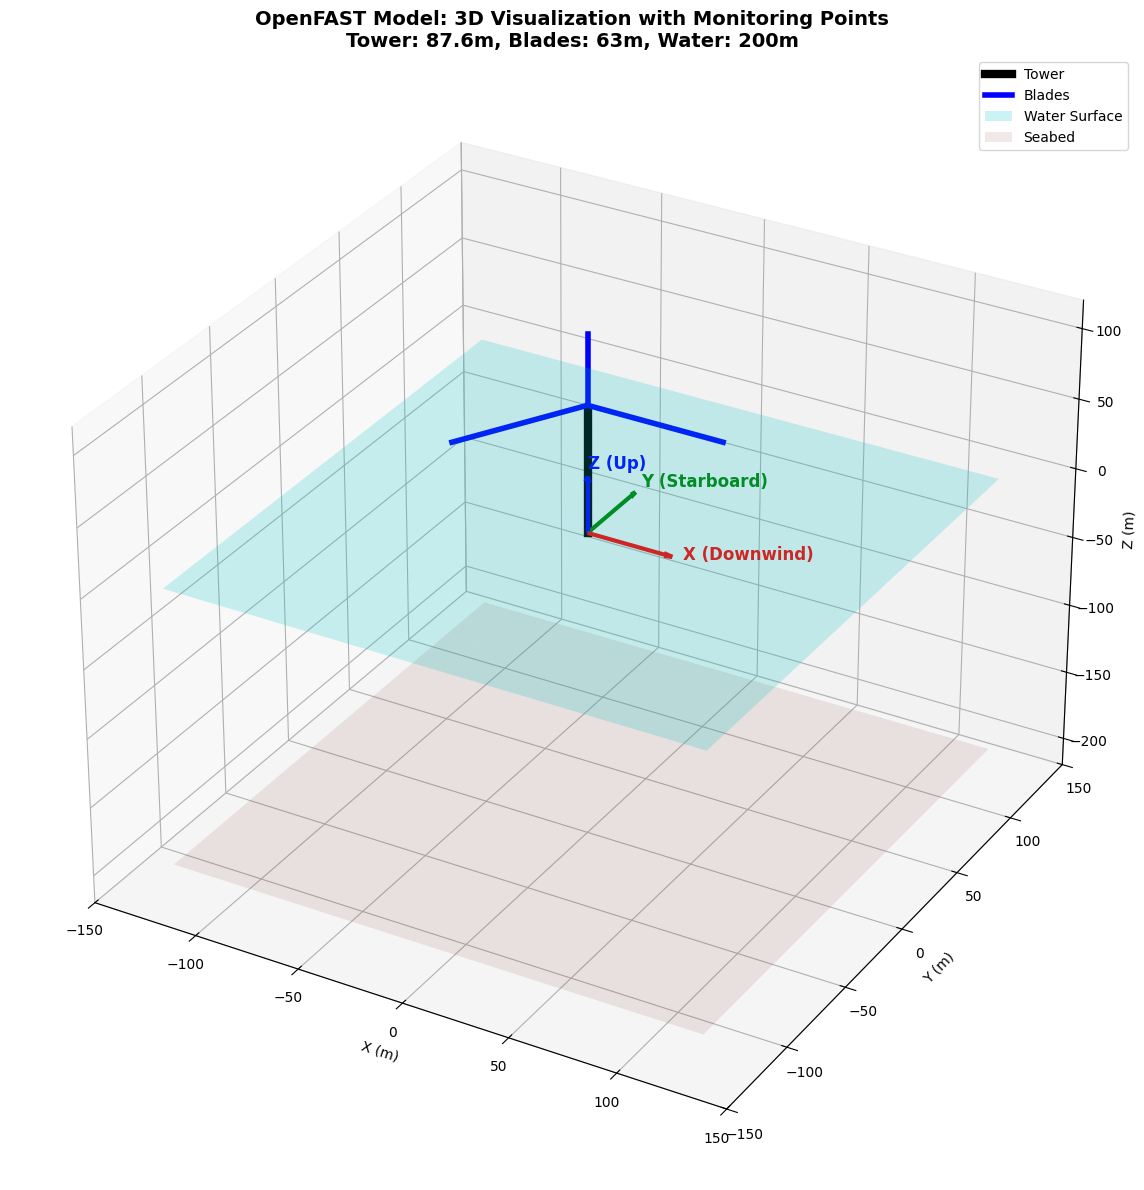


OPENFAST MODEL SUMMARY

STRUCTURAL DIMENSIONS:
  Tower Height: N/A m
  Blade Length: N/A m
  Number of Blades: N/A
  Water Depth: N/A m

MONITORING LOCATIONS:

COORDINATE SYSTEM:
  Origin: Platform reference point at MSL
  X-axis: Positive downwind
  Y-axis: Positive starboard (right looking downwind)
  Z-axis: Positive upward from MSL


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d  # Added this import
import re
import os

class OpenFASTVisualizer:
    """
    Generalized visualizer for OpenFAST models.
    Reads DAT files and creates 3D visualization with monitoring points.
    """
    
    def __init__(self):
        # Initialize data structures
        self.elastodyn_data = {}
        self.hydrodyn_data = {}
        self.moordyn_data = {}
        self.seastate_data = {}
        self.aerodyn_data = {}
        self.servodyn_data = {}
        
    def read_value(self, line, value_type=float):
        """Extract value from a line of DAT file"""
        # Split by whitespace and get first element
        parts = line.strip().split()
        if parts:
            try:
                return value_type(parts[0])
            except:
                return None
        return None
    
    def read_elastodyn(self, filepath):
        """
        Read ElastoDyn.dat file
        Required for: Tower height, hub height, blade properties, platform position
        """
        print(f"Reading ElastoDyn file: {filepath}")
        
        with open(filepath, 'r') as f:
            lines = f.readlines()
        
        for i, line in enumerate(lines):
            # Tower and hub configuration
            if 'TipRad' in line:
                self.elastodyn_data['blade_length'] = self.read_value(line)
            elif 'HubRad' in line:
                self.elastodyn_data['hub_radius'] = self.read_value(line)
            elif 'TowerHt' in line:
                self.elastodyn_data['tower_height'] = self.read_value(line)
            elif 'TowerBsHt' in line:
                self.elastodyn_data['tower_base_height'] = self.read_value(line)
            elif 'Twr2Shft' in line:
                self.elastodyn_data['tower_to_shaft'] = self.read_value(line)
            elif 'OverHang' in line:
                self.elastodyn_data['overhang'] = self.read_value(line)
            elif 'ShftTilt' in line:
                self.elastodyn_data['shaft_tilt'] = self.read_value(line)
            elif 'PreCone(1)' in line:
                self.elastodyn_data['precone'] = self.read_value(line)
            elif 'NumBl' in line:
                self.elastodyn_data['num_blades'] = self.read_value(line, int)
                
            # Platform reference position
            elif 'PtfmCMxt' in line:
                self.elastodyn_data['platform_cm_x'] = self.read_value(line)
            elif 'PtfmCMyt' in line:
                self.elastodyn_data['platform_cm_y'] = self.read_value(line)
            elif 'PtfmCMzt' in line:
                self.elastodyn_data['platform_cm_z'] = self.read_value(line)
            elif 'PtfmRefzt' in line:
                self.elastodyn_data['platform_ref_z'] = self.read_value(line)
                
            # Output monitoring locations
            elif 'NTwGages' in line:
                self.elastodyn_data['n_tower_gages'] = self.read_value(line, int)
            elif 'TwrGagNd' in line and self.elastodyn_data.get('n_tower_gages', 0) > 0:
                self.elastodyn_data['tower_gage_nodes'] = [self.read_value(line, int)]
            elif 'NBlGages' in line:
                self.elastodyn_data['n_blade_gages'] = self.read_value(line, int)
            elif 'BldGagNd' in line and self.elastodyn_data.get('n_blade_gages', 0) > 0:
                self.elastodyn_data['blade_gage_nodes'] = [self.read_value(line, int)]
                
        print(f"  - Found tower height: {self.elastodyn_data.get('tower_height')} m")
        print(f"  - Found blade length: {self.elastodyn_data.get('blade_length')} m")
        print(f"  - Number of blades: {self.elastodyn_data.get('num_blades')}")
        
    def read_hydrodyn(self, filepath):
        """
        Read HydroDyn.dat file
        Required for: Platform geometry, water depth, member properties
        """
        print(f"\nReading HydroDyn file: {filepath}")
        
        with open(filepath, 'r') as f:
            lines = f.readlines()
            
        # Initialize lists for members
        joints = []
        members = []
        reading_joints = False
        reading_members = False
        
        for i, line in enumerate(lines):
            # Water depth
            if 'WtrDpth' in line:
                self.hydrodyn_data['water_depth'] = self.read_value(line)
                if self.hydrodyn_data['water_depth'] == 'default':
                    self.hydrodyn_data['water_depth'] = 200  # Default for offshore
                    
            # Platform volume (for estimating size)
            elif 'PtfmVol0' in line:
                self.hydrodyn_data['platform_volume'] = self.read_value(line)
                
            # Joint definitions
            elif 'NJoints' in line:
                self.hydrodyn_data['n_joints'] = self.read_value(line, int)
                reading_joints = True
                joint_count = 0
            elif reading_joints and joint_count < self.hydrodyn_data.get('n_joints', 0):
                parts = line.strip().split()
                if len(parts) >= 5 and not any(word in line for word in ['JointID', '(-)']):
                    try:
                        joint = {
                            'id': int(parts[0]),
                            'x': float(parts[1]),
                            'y': float(parts[2]),
                            'z': float(parts[3])
                        }
                        joints.append(joint)
                        joint_count += 1
                    except:
                        pass
                        
            # Member properties
            elif 'PropD' in line and 'PropSetID' not in line:
                parts = line.strip().split()
                if len(parts) >= 2:
                    try:
                        self.hydrodyn_data['member_diameter'] = float(parts[1])
                    except:
                        pass
                        
        self.hydrodyn_data['joints'] = joints
        print(f"  - Water depth: {self.hydrodyn_data.get('water_depth')} m")
        print(f"  - Found {len(joints)} joints")
        
    def read_moordyn(self, filepath):
        """
        Read MoorDyn.dat file
        Required for: Mooring line configuration, anchor and fairlead positions
        """
        print(f"\nReading MoorDyn file: {filepath}")
        
        with open(filepath, 'r') as f:
            lines = f.readlines()
            
        points = []
        moorings = []
        reading_points = False
        reading_lines = False
        
        for i, line in enumerate(lines):
            # Point definitions (anchors and fairleads)
            if 'POINTS' in line.upper():
                reading_points = True
                continue
            elif 'LINES' in line.upper():
                reading_points = False
                reading_lines = True
                continue
                
            if reading_points:
                parts = line.strip().split()
                if len(parts) >= 8 and parts[0].isdigit():
                    try:
                        point = {
                            'id': int(parts[0]),
                            'type': parts[1],
                            'x': float(parts[2]),
                            'y': float(parts[3]),
                            'z': float(parts[4])
                        }
                        points.append(point)
                    except:
                        pass
                        
            # Line definitions
            if reading_lines:
                parts = line.strip().split()
                if len(parts) >= 5 and parts[0].isdigit():
                    try:
                        mooring = {
                            'id': int(parts[0]),
                            'attach_a': int(parts[2]),
                            'attach_b': int(parts[3]),
                            'length': float(parts[4])
                        }
                        moorings.append(mooring)
                    except:
                        pass
                        
        self.moordyn_data['points'] = points
        self.moordyn_data['lines'] = moorings
        print(f"  - Found {len(points)} mooring points")
        print(f"  - Found {len(moorings)} mooring lines")
        
    def read_seastate(self, filepath):
        """
        Read SeaState.dat file
        Required for: Wave monitoring points, water properties
        """
        print(f"\nReading SeaState file: {filepath}")
        
        with open(filepath, 'r') as f:
            lines = f.readlines()
            
        wave_elev_points = []
        wave_kin_points = []
        
        for i, line in enumerate(lines):
            # Water depth
            if 'WtrDpth' in line and 'Water depth' in line:
                value = self.read_value(line)
                if value and value != 'default':
                    self.seastate_data['water_depth'] = value
                    
            # Wave elevation points
            elif 'NWaveElev' in line:
                self.seastate_data['n_wave_elev'] = self.read_value(line, int)
            elif 'WaveElevxi' in line and self.seastate_data.get('n_wave_elev', 0) > 0:
                x_coords = [float(x) for x in re.findall(r'[-+]?\d*\.\d+|\d+', line.split('-')[0])]
                self.seastate_data['wave_elev_x'] = x_coords
            elif 'WaveElevyi' in line and self.seastate_data.get('n_wave_elev', 0) > 0:
                y_coords = [float(y) for y in re.findall(r'[-+]?\d*\.\d+|\d+', line.split('-')[0])]
                self.seastate_data['wave_elev_y'] = y_coords
                
            # Wave kinematics points
            elif 'NWaveKin' in line:
                self.seastate_data['n_wave_kin'] = self.read_value(line, int)
            elif 'WaveKinxi' in line and self.seastate_data.get('n_wave_kin', 0) > 0:
                x_coords = [float(x) for x in re.findall(r'[-+]?\d*\.\d+|\d+', line.split('-')[0])]
                self.seastate_data['wave_kin_x'] = x_coords
            elif 'WaveKinyi' in line and self.seastate_data.get('n_wave_kin', 0) > 0:
                y_coords = [float(y) for y in re.findall(r'[-+]?\d*\.\d+|\d+', line.split('-')[0])]
                self.seastate_data['wave_kin_y'] = y_coords
            elif 'WaveKinzi' in line and self.seastate_data.get('n_wave_kin', 0) > 0:
                z_coords = [float(z) for z in re.findall(r'[-+]?\d*\.\d+|\d+', line.split('-')[0])]
                self.seastate_data['wave_kin_z'] = z_coords
                
        print(f"  - Wave elevation points: {self.seastate_data.get('n_wave_elev', 0)}")
        print(f"  - Wave kinematics points: {self.seastate_data.get('n_wave_kin', 0)}")
        
    def visualize_3d(self):
        """
        Create 3D visualization using data from all input files
        """
        print("\nCreating 3D visualization...")
        
        # Get key dimensions
        tower_height = self.elastodyn_data.get('tower_height', 87.6)
        blade_length = self.elastodyn_data.get('blade_length', 63)
        hub_height = tower_height + self.elastodyn_data.get('tower_to_shaft', 2.4)
        water_depth = self.hydrodyn_data.get('water_depth', 200)
        num_blades = self.elastodyn_data.get('num_blades', 3)
        
        # Create figure
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(111, projection='3d')
        
        # 1. TOWER (from ElastoDyn)
        ax.plot([0, 0], [0, 0], [0, tower_height], 'k-', linewidth=6, label='Tower')
        
        # 2. ROTOR BLADES (from ElastoDyn)
        blade_angles = np.linspace(0, 360, num_blades, endpoint=False)
        for i, angle in enumerate(blade_angles):
            rad = np.radians(angle)
            blade_x = [0, blade_length * np.cos(rad)]
            blade_y = [0, blade_length * np.sin(rad)]
            blade_z = [hub_height, hub_height]
            ax.plot(blade_x, blade_y, blade_z, 'b-', linewidth=4, 
                   label='Blades' if i == 0 else '')
            
        # 3. PLATFORM (from HydroDyn joints)
        if self.hydrodyn_data.get('joints'):
            joints = self.hydrodyn_data['joints']
            # Draw platform outline
            for joint in joints:
                if joint['z'] > -50:  # Platform level
                    circle = plt.Circle((joint['x'], joint['y']), 2, color='gray', alpha=0.5)
                    ax.add_patch(circle)
                    art3d.pathpatch_2d_to_3d(circle, z=joint['z'], zdir="z")
                    
            # Connect platform joints
            if len(joints) >= 2:
                z_platform = joints[0]['z']
                diameter = self.hydrodyn_data.get('member_diameter', 18)
                theta = np.linspace(0, 2*np.pi, 50)
                x_platform = (diameter/2) * np.cos(theta)
                y_platform = (diameter/2) * np.sin(theta)
                ax.plot(x_platform, y_platform, [z_platform]*len(theta), 'gray', linewidth=2)
                
        # 4. MOORING LINES (from MoorDyn)
        if self.moordyn_data.get('points') and self.moordyn_data.get('lines'):
            points = self.moordyn_data['points']
            lines = self.moordyn_data['lines']
            
            for line in lines:
                # Find attachment points
                point_a = next((p for p in points if p['id'] == line['attach_a']), None)
                point_b = next((p for p in points if p['id'] == line['attach_b']), None)
                
                if point_a and point_b:
                    ax.plot([point_a['x'], point_b['x']], 
                           [point_a['y'], point_b['y']], 
                           [point_a['z'], point_b['z']], 
                           'r--', linewidth=1.5, alpha=0.7)
                           
        # 5. WATER SURFACE (from SeaState/HydroDyn)
        water_size = max(100, blade_length * 2)
        xx, yy = np.meshgrid(np.linspace(-water_size, water_size, 20), 
                            np.linspace(-water_size, water_size, 20))
        zz = np.zeros_like(xx)
        ax.plot_surface(xx, yy, zz, alpha=0.2, color='cyan', label='Water Surface')
        
        # 6. SEABED
        seabed = np.full_like(xx, -water_depth)
        ax.plot_surface(xx, yy, seabed, alpha=0.1, color='brown', label='Seabed')
        
        # 7. MONITORING POINTS
        
        # Wave kinematics points (from SeaState)
        if all(key in self.seastate_data for key in ['wave_kin_x', 'wave_kin_y', 'wave_kin_z']):
            ax.scatter(self.seastate_data['wave_kin_x'], 
                      self.seastate_data['wave_kin_y'], 
                      self.seastate_data['wave_kin_z'], 
                      c='orange', s=150, marker='o', 
                      label='Wave Kinematics Points', edgecolors='black')
                      
        # Tower monitoring (from ElastoDyn)
        if self.elastodyn_data.get('tower_gage_nodes'):
            for node in self.elastodyn_data['tower_gage_nodes']:
                # Approximate height based on node number (assuming uniform distribution)
                n_tower_nodes = 20  # Default from ElastoDyn
                node_height = (node / n_tower_nodes) * tower_height
                ax.scatter([0], [0], [node_height], c='green', s=150, 
                          marker='s', label=f'Tower Node {node}', edgecolors='black')
                          
        # Blade monitoring (from ElastoDyn)
        if self.elastodyn_data.get('blade_gage_nodes'):
            for node in self.elastodyn_data['blade_gage_nodes']:
                # Approximate radius based on node number
                n_blade_nodes = 17  # Default from ElastoDyn
                node_radius = (node / n_blade_nodes) * blade_length
                ax.scatter([node_radius], [0], [hub_height], c='purple', s=150, 
                          marker='^', label=f'Blade Node {node}', edgecolors='black')
                          
        # 8. COORDINATE SYSTEM ARROWS
        arrow_length = 40
        ax.quiver(0, 0, 0, arrow_length, 0, 0, color='red', arrow_length_ratio=0.1, linewidth=3)
        ax.quiver(0, 0, 0, 0, arrow_length, 0, color='green', arrow_length_ratio=0.1, linewidth=3)
        ax.quiver(0, 0, 0, 0, 0, arrow_length, color='blue', arrow_length_ratio=0.1, linewidth=3)
        
        ax.text(arrow_length+5, 0, 0, 'X (Downwind)', color='red', fontsize=12, weight='bold')
        ax.text(0, arrow_length+5, 0, 'Y (Starboard)', color='green', fontsize=12, weight='bold')
        ax.text(0, 0, arrow_length+5, 'Z (Up)', color='blue', fontsize=12, weight='bold')
        
        # Set labels and title
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_zlabel('Z (m)')
        ax.set_title('OpenFAST Model: 3D Visualization with Monitoring Points\n' + 
                    f'Tower: {tower_height}m, Blades: {blade_length}m, Water: {water_depth}m', 
                    fontsize=14, weight='bold')
                    
        # Set view limits
        max_range = max(blade_length * 1.5, 150)
        ax.set_xlim([-max_range, max_range])
        ax.set_ylim([-max_range, max_range])
        ax.set_zlim([-water_depth-20, hub_height+30])
        
        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = []
        unique_handles = []
        for i, label in enumerate(labels):
            if label not in unique_labels:
                unique_labels.append(label)
                unique_handles.append(handles[i])
        ax.legend(unique_handles, unique_labels, loc='upper right')
        
        plt.tight_layout()
        plt.show()
        
    def print_summary(self):
        """Print summary of all monitoring points and key dimensions"""
        print("\n" + "="*60)
        print("OPENFAST MODEL SUMMARY")
        print("="*60)
        
        print("\nSTRUCTURAL DIMENSIONS:")
        print(f"  Tower Height: {self.elastodyn_data.get('tower_height', 'N/A')} m")
        print(f"  Blade Length: {self.elastodyn_data.get('blade_length', 'N/A')} m")
        print(f"  Number of Blades: {self.elastodyn_data.get('num_blades', 'N/A')}")
        print(f"  Water Depth: {self.hydrodyn_data.get('water_depth', 'N/A')} m")
        
        print("\nMONITORING LOCATIONS:")
        
        if self.elastodyn_data.get('tower_gage_nodes'):
            print(f"  Tower Sensors: Nodes {self.elastodyn_data['tower_gage_nodes']}")
            
        if self.elastodyn_data.get('blade_gage_nodes'):
            print(f"  Blade Sensors: Nodes {self.elastodyn_data['blade_gage_nodes']}")
            
        if self.seastate_data.get('n_wave_kin', 0) > 0:
            print(f"  Wave Kinematics Points: {self.seastate_data['n_wave_kin']}")
            for i in range(self.seastate_data['n_wave_kin']):
                if all(key in self.seastate_data for key in ['wave_kin_x', 'wave_kin_y', 'wave_kin_z']):
                    print(f"    Point {i+1}: ({self.seastate_data['wave_kin_x'][i]}, " +
                          f"{self.seastate_data['wave_kin_y'][i]}, " +
                          f"{self.seastate_data['wave_kin_z'][i]}) m")
                          
        if self.moordyn_data.get('lines'):
            print(f"  Mooring Lines: {len(self.moordyn_data['lines'])} lines")
            
        print("\nCOORDINATE SYSTEM:")
        print("  Origin: Platform reference point at MSL")
        print("  X-axis: Positive downwind")
        print("  Y-axis: Positive starboard (right looking downwind)")
        print("  Z-axis: Positive upward from MSL")
        

# Main execution
if __name__ == "__main__":
    # Create visualizer instance
    viz = OpenFASTVisualizer()
    
    # Define file paths - update these to match your file locations
    file_paths = {
        'elastodyn': 'NRELOffshrBsline5MW_MIT_NREL_TLP_ElastoDyn.dat',
        'hydrodyn': 'NRELOffshrBsline5MW_MIT_NREL_TLP_HydroDyn.dat',
        'moordyn': 'NRELOffshrBsline5MW_MIT_NREL_TLP_MoorDyn.dat',
        'seastate': 'SeaState.dat',
        # Add more as needed:
        'aerodyn': 'NRELOffshrBsline5MW_Onshore_AeroDyn.dat',
        'servodyn': 'NRELOffshrBsline5MW_MIT_NREL_TLP_ServoDyn.dat',
    }
    
    # Read files (check if they exist first)
    print("READING OPENFAST INPUT FILES")
    print("-" * 60)
    
    for file_type, filepath in file_paths.items():
        if os.path.exists(filepath):
            if file_type == 'elastodyn':
                viz.read_elastodyn(filepath)
            elif file_type == 'hydrodyn':
                viz.read_hydrodyn(filepath)
            elif file_type == 'moordyn':
                viz.read_moordyn(filepath)
            elif file_type == 'seastate':
                viz.read_seastate(filepath)
        else:
            print(f"Warning: {filepath} not found")
            
    # Create visualization
    viz.visualize_3d()
    
    # Print summary
    viz.print_summary()